In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import pandas as pd
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import os
from datetime import timedelta

In [3]:
import bsose.preprocess as pp

In [4]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4_3D, ErrorCode

### Load b-sose

In [5]:
ds,xgrid = pp.load_bsose()
ds = ds.isel(time=slice(0,10)) # isolate time period

### Interpolate velocities to same point

In [6]:
ds['UVELT'] = xgrid.interp(ds['UVEL'],'X')
ds['VVELT'] = xgrid.interp(ds['VVEL'],'Y',boundary='extrapolate')
ds['WVELT'] = xgrid.interp(ds['WVEL'],'Z',boundary='extrapolate')

### Define FieldSet

In [7]:
variables = {'U': 'UVELT',
             'V': 'VVELT',
             'W': 'WVELT'}
dimensions = {'U':{'lon':'XC','lat':'YC','depth':'Z','time':'time'},
             'V':{'lon':'XC','lat':'YC','depth':'Z','time':'time'},
             'W':{'lon':'XC','lat':'YC','depth':'Z','time':'time'}}
fs = FieldSet.from_xarray_dataset(ds,variables,dimensions)

SyntaxError: Field received an unexpected keyword argument "deferred_load" (<string>)

In [8]:
N = 1000
lats = np.linspace(-60,-55,N)
lons=300*np.ones(N)
depths=-1*np.linspace(1000,1100,N)
times=fs.U.grid.time[-1]
pset = ParticleSet(fieldset=fs, pclass=JITParticle,
                  lon=lons,lat=lats,depth=depths,time=times)  

### Run and save particles

In [9]:
if os.path.isfile("output.nc"):
    os.remove("output.nc")
output_file = pset.ParticleFile(name="output.nc", outputdt=timedelta(days=1))

kernel = AdvectionRK4_3D

pset.execute(kernel,
             runtime=timedelta(days=100),
             dt=-timedelta(minutes=60),
             output_file=output_file)
output_file.export()


INFO: Compiled JITParticleAdvectionRK4_3D ==> /tmp/parcels-995200043/35df6df6e82495d0deac1b4c3066425b_0.so
INFO: Temporary output files are stored in out-MDAHVFEN.
INFO: You can use "parcels_convert_npydir_to_netcdf out-MDAHVFEN" to convert these to a NetCDF file during the run.
100% (8640000.0 of 8640000.0) |##########| Elapsed Time: 0:35:41 Time:  0:35:41


In [10]:
try:
    output.close()
    print('output closed')
except:
    pass
output = xr.open_dataset('output.nc', cache=False, decode_times=False)

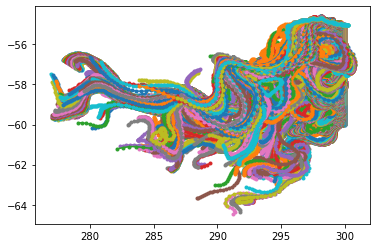

In [11]:
plt.plot(output['lon'].transpose(),output['lat'].transpose(),'.-');

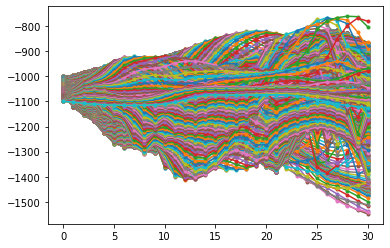

In [67]:
fig,ax = plt.subplots()
ax.plot(output['z'].transpose(),'.-');